
# Model Comparison: Baselines vs XGB and STL+XGB



## Scope
- Load **metrics** and **predictions** from:
  - Baselines (`metrics_<project>.csv`, `preds_<project>.parquet`)
  - XGB direct (`metrics_xgb_<project>.csv`, `preds_xgb_<project>.parquet`)
  - STL+XGB hybrid (`metrics_stl_xgb_<project>.csv`, `preds_stl_xgb_<project>.parquet`)
.



Setup & configuration



In [1]:

# --- Configuration ---
PROJECT = "ssta_plymouth"     # <- change if your files use a different project name
PROCESSED_DIR = "../data/processed"

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore

def detect_metrics_path(stem: str, project: str) -> Path:
    cand = Path(PROCESSED_DIR) / f"{stem}_{project}.csv"
    if cand.exists():
        return cand
   
    matches = sorted(Path(PROCESSED_DIR).glob(f"{stem}_*.csv"))
    if not matches:
        raise FileNotFoundError(f"No {stem}_<project>.csv found in {PROCESSED_DIR}")
    return matches[-1]

def detect_preds_path(stem: str, project: str) -> Path:
    cand = Path(PROCESSED_DIR) / f"{stem}_{project}.parquet"
    if cand.exists():
        return cand
    
    matches = sorted(Path(PROCESSED_DIR).glob(f"{stem}_*.parquet"))
    if not matches:
        raise FileNotFoundError(f"No {stem}_<project>.parquet found in {PROCESSED_DIR}")
    return matches[-1]


m_base = detect_metrics_path("metrics", PROJECT)
p_base = detect_preds_path("preds", PROJECT)

m_xgb  = detect_metrics_path("metrics_xgb", PROJECT)
p_xgb  = detect_preds_path("preds_xgb", PROJECT)

m_stl  = detect_metrics_path("metrics_stl_xgb", PROJECT)
p_stl  = detect_preds_path("preds_stl_xgb", PROJECT)

print("Loaded:")
print(" ", m_base.name, p_base.name)
print(" ", m_xgb.name,  p_xgb.name)
print(" ", m_stl.name,  p_stl.name)

# Read all
metrics_base = pd.read_csv(m_base)
metrics_xgb  = pd.read_csv(m_xgb)
metrics_stl  = pd.read_csv(m_stl)

def load_preds(path: Path) -> pd.DataFrame:
    df = pd.read_parquet(path)
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    return df.dropna(subset=["date"]).sort_values(["date","horizon","model"]).reset_index(drop=True)

preds_base = load_preds(p_base)
preds_xgb  = load_preds(p_xgb)
preds_stl  = load_preds(p_stl)

# Normalize model names for neat plots
metrics_xgb["model"] = metrics_xgb.get("model", "xgb_direct")
metrics_stl["model"] = metrics_stl.get("model", "stl+xgb_resid")
preds_xgb["model"]   = preds_xgb.get("model", "xgb_direct")
preds_stl["model"]   = preds_stl.get("model", "stl+xgb_resid")


Loaded:
  metrics_ssta_plymouth.csv preds_ssta_plymouth.parquet
  metrics_xgb_ssta_plymouth.csv preds_xgb_ssta_plymouth.parquet
  metrics_stl_xgb_ssta_plymouth.csv preds_stl_xgb_ssta_plymouth.parquet



## 1. Unified leaderboards

concatenate all metrics and produce per-horizon leaderboards (sorted by MAE).


In [2]:

metrics_all = pd.concat([metrics_base, metrics_xgb, metrics_stl], ignore_index=True, sort=False)
metrics_all = metrics_all.sort_values(["horizon","MAE"]).reset_index(drop=True)

print("Unified metrics (top 12 rows):")
print(metrics_all.head(12).to_string(index=False))

def leaderboard_for_h(h):
    m = metrics_all[metrics_all["horizon"] == h].copy()
    return m.sort_values("MAE")[["horizon","model","MAE","RMSE","sMAPE","MASE"]]

for h in sorted(metrics_all["horizon"].unique()):
    print("\n=== LEADERBOARD: Horizon +%d months ===" % h)
    print(leaderboard_for_h(h).to_string(index=False))


Unified metrics (top 12 rows):
 horizon                   model      MAE     RMSE      sMAPE     MASE  Skill_vs_Climo_%
       1              xgb_direct 0.410519 0.524259 112.572362 0.688649               NaN
       1 sarima(1,0,0)(1,0,0,12) 0.439933 0.560794 112.555903 0.747585         26.105878
       1           stl+xgb_resid 0.461517 0.581361 115.001906      NaN               NaN
       1          seasonal_naive 0.588473 0.773152 130.029877 1.000000          1.156197
       1             climatology 0.595356 0.712816 163.138279 1.011697          0.000000
       3              xgb_direct 0.416868 0.525395 110.417491 0.706502               NaN
       3           stl+xgb_resid 0.471936 0.598579 114.893515      NaN               NaN
       3 sarima(1,0,0)(1,0,0,12) 0.480594 0.605365 134.919275 0.829453         19.825254
       3          seasonal_naive 0.579411 0.762619 128.654230 1.000000          3.340179
       3             climatology 0.599433 0.720399 163.138279 1.034556         


## 2. MAE by model per horizon

Bar plots of MAE, one panel per horizon.


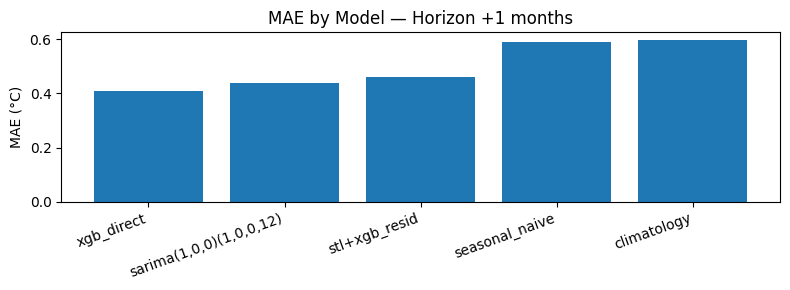

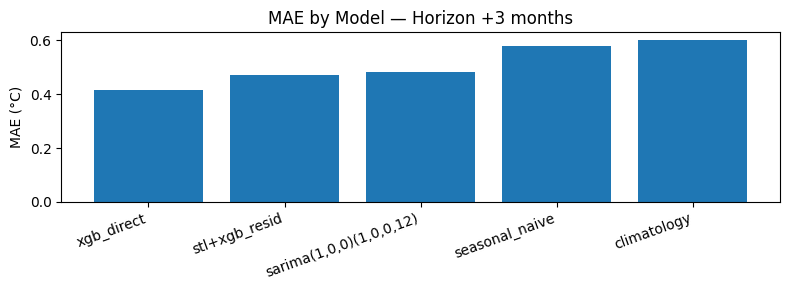

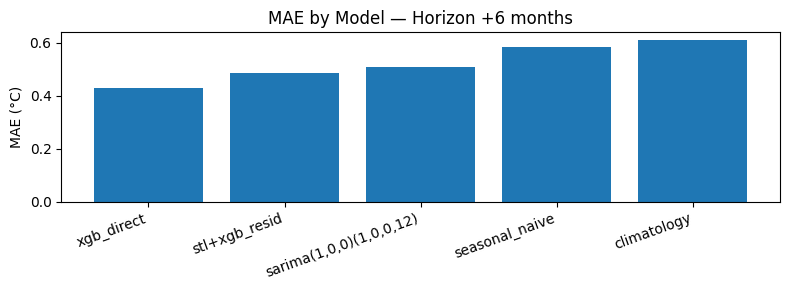

In [3]:

def plot_mae_by_model(h):
    m = metrics_all[metrics_all["horizon"] == h].copy()
    labels = m["model"].tolist()
    vals = m["MAE"].tolist()
    plt.figure(figsize=(8,3))
    plt.bar(range(len(labels)), vals)
    plt.xticks(range(len(labels)), labels, rotation=20, ha="right")
    plt.ylabel("MAE (°C)")
    plt.title(f"MAE by Model — Horizon +{h} months")
    plt.tight_layout(); plt.show()

for h in sorted(metrics_all["horizon"].unique()):
    plot_mae_by_model(int(h))



## 3. Forecast vs. actuals (overlay)

We overlay forecasts from the **best model** at each horizon against actuals.  



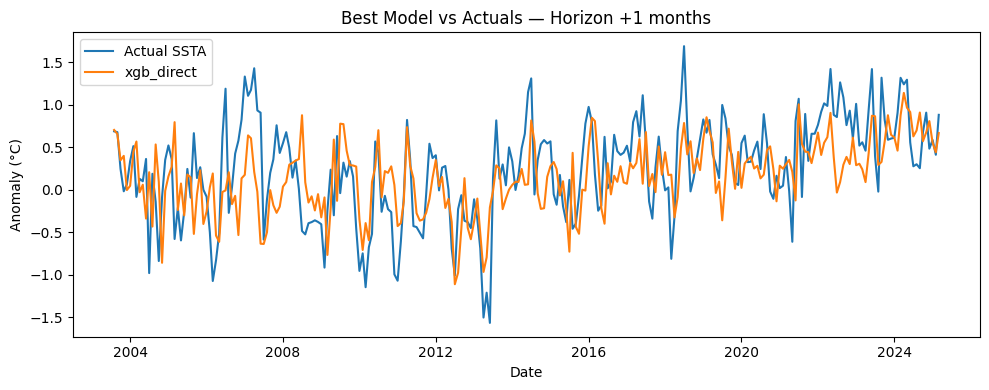

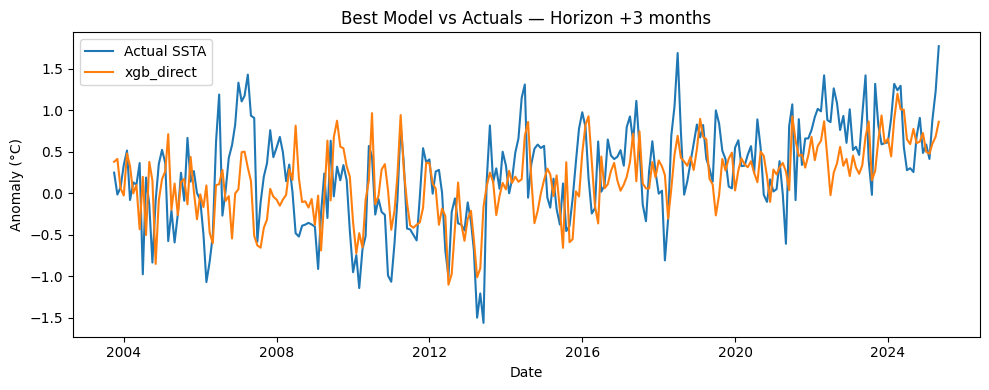

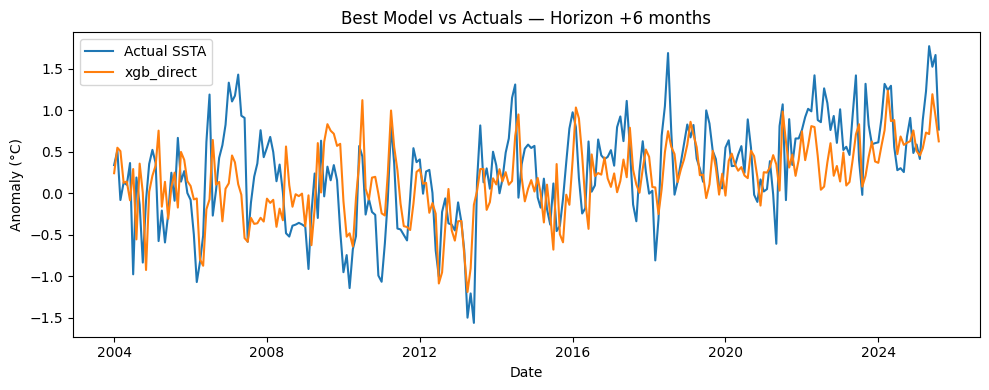

In [4]:

# Helper to get preds df by model keyword
def get_preds_for_model(name_keyword: str):
    if "xgb" in name_keyword and "stl" not in name_keyword:
        return preds_xgb
    if "stl" in name_keyword:
        return preds_stl
    return preds_base

def plot_best_overlay(h):
    m = leaderboard_for_h(h)
    best_model = str(m.iloc[0]["model"])
    source = get_preds_for_model(best_model)
    p = source[source["horizon"] == h].copy()
    if p.empty:
        print(f"No predictions for horizon={h} in {best_model}.")
        return
    
    actual = p[["date","y_true"]].drop_duplicates().sort_values("date")
    plt.figure(figsize=(10,4))
    plt.plot(actual["date"], actual["y_true"], label="Actual SSTA")
    # Forecast
    pm = p[p["model"] == best_model].sort_values("date")
    plt.plot(pm["date"], pm["y_pred"], label=best_model)
    plt.title(f"Best Model vs Actuals — Horizon +{h} months")
    plt.xlabel("Date"); plt.ylabel("Anomaly (°C)")
    plt.legend()
    plt.tight_layout(); plt.show()

for h in sorted(metrics_all["horizon"].unique()):
    plot_best_overlay(int(h))



## 4. Relative improvement

Compare each model’s MAE to the **seasonal naïve** baseline at the same horizon.


In [5]:

def improvement_vs_seasonal_naive(h):
    m = metrics_all[metrics_all["horizon"] == h].copy()
    base = m[m["model"].str.contains("seasonal_naive")]["MAE"]
    if base.empty:
        print(f"Seasonal naïve not found for horizon {h}.")
        return
    b = float(base.iloc[0])
    m = m.assign(Improvement_vs_Seasonal_Naive_pct = 100.0 * (1.0 - m["MAE"] / b))
    print(m[["model","MAE","Improvement_vs_Seasonal_Naive_pct"]].sort_values("MAE").to_string(index=False))

for h in sorted(metrics_all["horizon"].unique()):
    print(f"\n=== Improvement vs Seasonal Naïve — h=+{h} ===")
    improvement_vs_seasonal_naive(int(h))



=== Improvement vs Seasonal Naïve — h=+1 ===
                  model      MAE  Improvement_vs_Seasonal_Naive_pct
             xgb_direct 0.410519                          30.239887
sarima(1,0,0)(1,0,0,12) 0.439933                          25.241523
          stl+xgb_resid 0.461517                          21.573802
         seasonal_naive 0.588473                           0.000000
            climatology 0.595356                          -1.169721

=== Improvement vs Seasonal Naïve — h=+3 ===
                  model      MAE  Improvement_vs_Seasonal_Naive_pct
             xgb_direct 0.416868                          28.053169
          stl+xgb_resid 0.471936                          18.548956
sarima(1,0,0)(1,0,0,12) 0.480594                          17.054734
         seasonal_naive 0.579411                           0.000000
            climatology 0.599433                          -3.455602

=== Improvement vs Seasonal Naïve — h=+6 ===
                  model      MAE  Improvement_